In [1]:
"""
Calculating image texture metrics
"""

import os, sys, time
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import earthpy.plot as ep
import gc

from scipy.ndimage import generic_filter

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N (Washington, D.C.)

print("Ready !")

Ready !


In [2]:
stack_out_norm_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_fil_sc.tif')
da_stack = rxr.open_rasterio(stack_out_norm_fp, masked=True,cache=False).squeeze()
print(da_stack)

<xarray.DataArray (band: 5, y: 8223, x: 6714)> Size: 1GB
[276046110 values with dtype=float32]
Coordinates:
  * band         (band) int64 40B 1 2 3 4 5
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        6.061776638031
    STATISTICS_MEAN:           -0.0047270352211715
    STATISTICS_MINIMUM:        -2.8689451217651
    STATISTICS_STDDEV:         0.99201173971464
    STATISTICS_VALID_PERCENT:  98.94
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1')


In [3]:
# Select the NISI band for analysis
nisi_band = da_stack[3]
print(nisi_band)

<xarray.DataArray (y: 8223, x: 6714)> Size: 221MB
[55209222 values with dtype=float32]
Coordinates:
    band         int64 8B 4
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        6.061776638031
    STATISTICS_MEAN:           -0.0047270352211715
    STATISTICS_MINIMUM:        -2.8689451217651
    STATISTICS_STDDEV:         0.99201173971464
    STATISTICS_VALID_PERCENT:  98.94
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1')


#### Calculate Simple Texture Features

Now that we have an image stack of uncorrelated bands, we can use some feature extraction to create additional data. In particular, creating textural metrics from the spectral data may improve image classification. In the section below, we calculate image texture using a simple moving window analysis on the Normalised Impervious Surface Index (NISI).

Processing a 9x9 window size ...


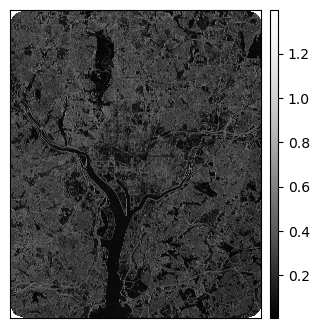

Elapsed time for 9x9: 7.02 minutes.
Processing a 27x27 window size ...


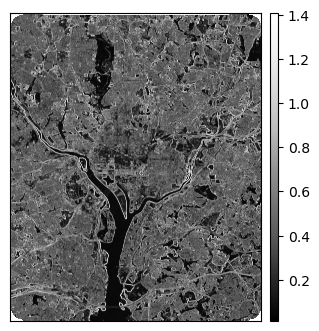

Elapsed time for 27x27: 8.31 minutes.
Total elapsed time: 15.32 minutes.


In [4]:
t0 = time.time()

# Define the window size (N x N)
window_sizes = [9,27]  # 9x9,27x27

da_out = {}

for window_size in window_sizes:
    t00 = time.time()
    name = str(window_size)+'x'+str(window_size)
    print(f"Processing a {name} window size ...")
    
    # Calculate the standard deviation using a moving window
    nisi_std = generic_filter(nisi_band, np.std, size=window_size)
    
    # Convert the result to a DataArray with the same coordinates and dimensions as the original band
    nisi_std_da = xr.DataArray(
        nisi_std,
        dims=nisi_band.dims,
        coords=nisi_band.coords,
        attrs=nisi_band.attrs
    )

    # Prep the array for export as a GeoTIFF
    # Assign the long name attribute
    nisi_std_da.attrs['long_name'] = 'NISI'+str(name)
    nisi_std_da.rio.write_crs(proj, inplace=True) # write the CRS

    # Plot the result to visualize the texture
    ep.plot_bands(nisi_std_da, figsize=(4,4))

    da_out[name] = nisi_std_da

    t1 = (time.time() - t00) / 60
    print(f"Elapsed time for {name}: {t1:.2f} minutes.")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

In [5]:
# Create a multiband image stack from the results
da_texture = xr.concat(list(da_out.values()), dim='band')
# Assign band labels (window sizes) as a coordinate for the 'band' dimension
da_texture = da_texture.assign_coords(band=np.arange(6, 6 + len(da_out)))
# Set the long_name attribute for each band
new_names = ['NISI9x9','NISI27x27']
da_texture.attrs['long_name'] = tuple(new_names)
# View the shape of the multiband texture stack
print(da_texture)

<xarray.DataArray (band: 2, y: 8223, x: 6714)> Size: 442MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 16B 6 7
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        6.06177

['NISI9x9', 'NISI27x27']


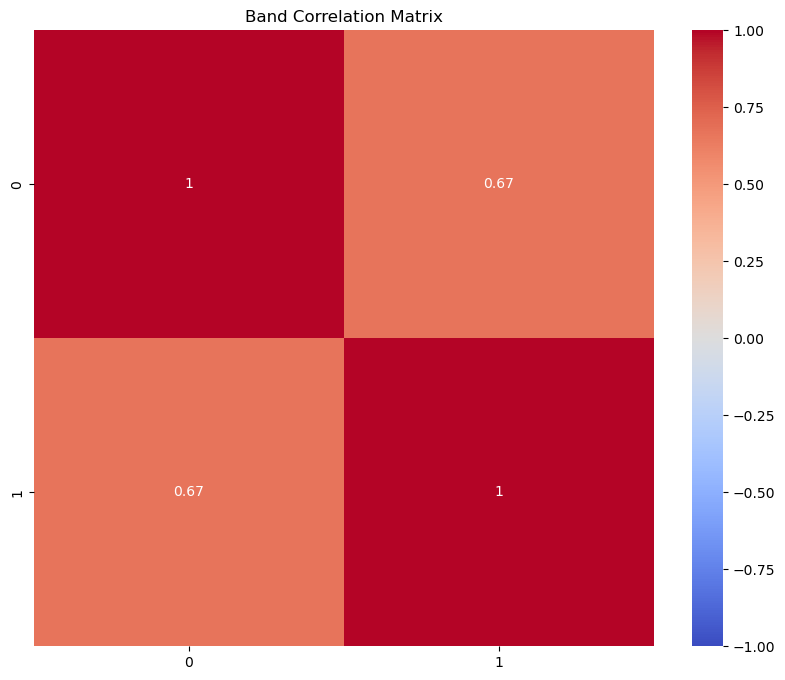

10251

In [6]:
# Test the band correlations to make sure we can keep them all ...
print(new_names)
# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_texture.png')
band_correlations(da_texture, out_png)
gc.collect()

In [7]:
# Merge with the original data
stack_out = xr.concat([da_stack, da_texture], dim='band') # Concatenate all bands
print(stack_out.shape)

(7, 8223, 6714)


In [8]:
# Save the normalized image array out with the correct CRS and compression
da_texture_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_nisi_text.tif')
da_texture.rio.to_raster(da_texture_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')

print(f"Saved raster stack to: {da_texture_fp}")

Saved raster stack to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_nisi_text.tif


### Graylevel Co-Occurrence Matrix (GLCM) Method

The GLCM method is a more robust way for calculating texture features from image data. 

GLCM Contrast: Measures the difference in intensity between neighboring pixels in a window. It is based on the co-occurrence matrix and captures more localized intensity variations.

In [ ]:
# t0 = time.time()

# # Convert NIR band to uint8 (GLCM requires integer values)
# nir_band_fill = nir_band.fillna(-9999)  # Replace NaN with 0 or another suitable value
# nir_band_uint8 = (nir_band_fill * 255 / nir_band_fill.max()).astype(np.uint8)

# # Define the window size for the GLCM calculation
# window_size = 5

# # Initialize a new array to store the GLCM contrast (or other metrics)
# nir_glcm_con = np.zeros_like(nir_band_uint8)

# # Calculate GLCM contrast in a moving window
# for i in range(window_size//2, nir_band_uint8.shape[0] - window_size//2):
#     for j in range(window_size//2, nir_band_uint8.shape[1] - window_size//2):
#         # Extract the local window
#         window = nir_band_uint8[i - window_size//2: i + window_size//2 + 1,
#                                 j - window_size//2: j + window_size//2 + 1]
        
#         # Calculate GLCM
#         glcm = graycomatrix(window, [1], [0], symmetric=True, normed=True)
        
#         # Calculate GLCM contrast and store in the array
#         contrast = graycoprops(glcm, 'contrast')[0, 0]
#         nir_glcm_con[i, j] = contrast

# # Convert the result to a DataArray
# nir_glcm_con_da = xr.DataArray(
#     nir_glcm_contrast,
#     dims=nir_band_uint8.dims,
#     coords=nir_band_uint8.coords,
#     attrs=nir_band_uint8.attrs
# )

# # Plot the result to visualize the texture
# ep.plot_bands(nir_glcm_con_da, figsize=(4,4))

# t1 = (time.time() - t0) / 60
# print(f"Total elapsed time: {t1:.2f} minutes.")